In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def values(func, left, right, n):
    return func(np.linspace(left, right, n))

Функции, которые работают:

In [2]:
def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert eps > 0
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas >= eps * sigmas[0]).sum())
        #поменял eps-стратегию в соответствие с кодом из репозитория
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

In [3]:
def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [4]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

In [5]:
modes = [2] * d
ranks = [2] * (d - 1)

filters, _ = wtt_filter(
    sqrt_x_values,
    d,
    modes,
    ranks=ranks,
    check_correctness=True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)

Пайплайн для счёта общей матрицы преобразования $W$:

In [6]:
W = filters[-1].T
I = np.eye(modes[-1])
for k in range(d - 2, -1, -1):
    r = ranks[k]
    r_prev = 1 if k == 0 else ranks[k - 1]
    m = modes[k]

    assert I.shape[0] == I.shape[1] == np.prod(modes[k + 1:])
    
    E = np.eye(r_prev * m, r) 

    R = filters[k][:,:r]
    assert np.allclose(R, filters[k] @ E)

    P = filters[k] * np.array(
        [0.] * r + [1.] * (m * r_prev - r)
    )
    assert np.allclose(P, filters[k] @ (np.eye(r_prev * m) - E @ E.T))
    
    W = np.kron(I, E) @ W @ np.kron(I, R.T) + np.kron(I, P.T)
    I = np.kron(np.eye(m), I)

TODO: возможно, крону с единичной матрицей можно ускорить.

В отличие от статьи, надо поменять порядок в кронах. Стандартная крона:
$$
A \otimes B =
\begin{pmatrix}
a_{11} B & \ldots & a_{1n}B \\
\vdots & \ddots & \vdots \\
a_{m1} B & \ldots & a_{mn}B \\
\end{pmatrix}
$$

Индексы бегают быстрее из $B$, потом --- из $A$. Но раз в той же статье мы хотим $$W_{i_1,...,i_k; j_1,...,j_k} = V^{(1)}_{i_1,j_1} \ldots V^{(k)}_{i_k,k_k} \Rightarrow W = V_1 \otimes \ldots \otimes V_k$$, а запись $W_{i_1,...,i_k; j_1,...,j_k}$ подразумевает, что левые индексы меняются быстро, правые --- медленно (Fortran порядок), то крона должна действовать не как обычно. В общем, при кроне у левой матрицы индексы должны меняться быстро, у правой --- медленно.

In [7]:
W.shape

(1024, 1024)

In [8]:
assert np.allclose(W @ sqrt_x_values, wtt_res)

Как я понимаю, базисные функции --- строки итоговой матрицы (м.б. с нормированием):

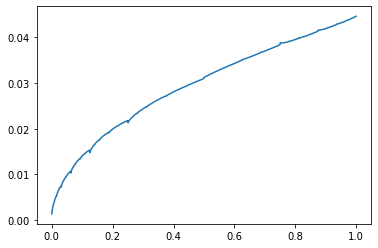

In [9]:
plt.plot(linspace, W[0,:])

Ага, форма такая, но граничные значения разнятся.

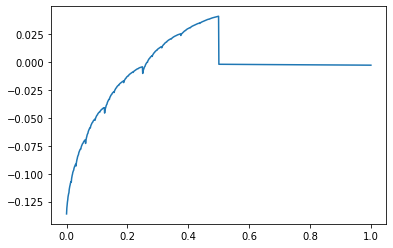

In [10]:
plt.plot(linspace, W[1,:])

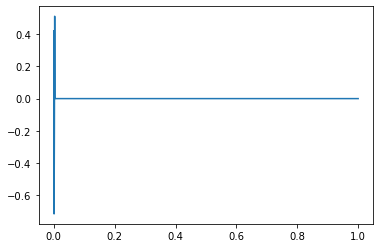

In [11]:
plt.plot(linspace, W[2,:])

Коэффициенты для корня:

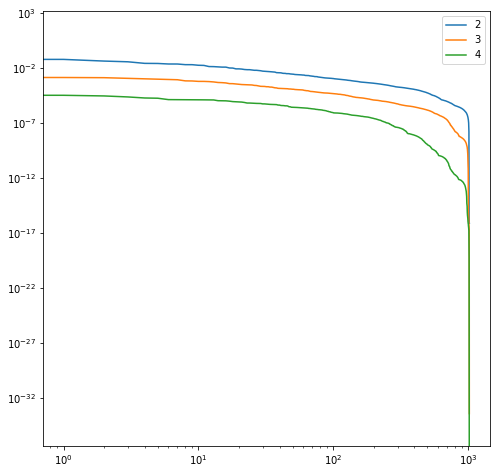

In [12]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)
sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

wtt_coefs_sqrt = []
for r in [2, 3, 4]:
    modes = [2] * d
    ranks = [2] + [r] * (d - 2)

    filters, _ = wtt_filter(
        sqrt_x_values,
        d,
        modes,
        ranks=ranks,
        check_correctness=True
    )
    wtt_res = wtt_apply(
        sqrt_x_values,
        d,
        filters,
        modes,
        ranks,
        True
    )
    wtt_coefs_sqrt.append(np.flip(np.sort(np.abs(wtt_res))))
    
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d), wtt_coefs_sqrt[i], label=str(r))
plt.xscale('log')
plt.yscale('log')
plt.legend()

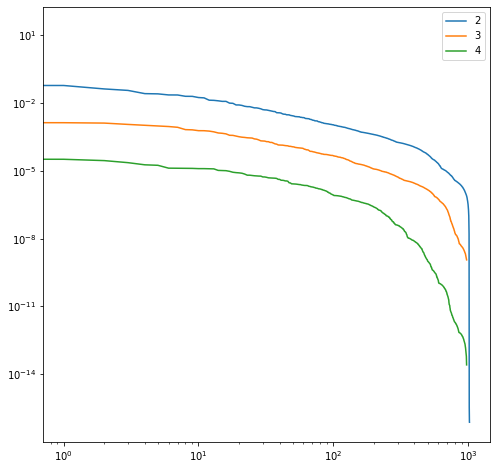

In [13]:
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    if r == 2:
        plt.plot(np.arange(2 ** d), wtt_coefs_sqrt[i], label=str(r))
    else:
        plt.plot(np.arange(2 ** d)[:975], wtt_coefs_sqrt[i][:975], label=str(r))
plt.xscale('log')
plt.yscale('log')
plt.legend()

Базисные функции для синуса:

In [14]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sin_sq_values = values(lambda x: np.sin(500 * x ** 2), left, right, n)

In [15]:
modes = [2] * d
ranks = [2] * (d - 1)

filters, _ = wtt_filter(
    sin_sq_values,
    d,
    modes,
    ranks=ranks,
    check_correctness=True
)
wtt_res = wtt_apply(
    sqrt_x_values,
    d,
    filters,
    modes,
    ranks,
    True
)

In [16]:
W = filters[-1].T
I = np.eye(modes[-1])
for k in range(d - 2, -1, -1):
    r = ranks[k]
    r_prev = 1 if k == 0 else ranks[k - 1]
    m = modes[k]

    assert I.shape[0] == I.shape[1] == np.prod(modes[k + 1:])
    
    E = np.eye(r_prev * m, r) 

    R = filters[k][:,:r]
    assert np.allclose(R, filters[k] @ E)

    P = filters[k] * np.array(
        [0.] * r + [1.] * (m * r_prev - r)
    )
    assert np.allclose(P, filters[k] @ (np.eye(r_prev * m) - E @ E.T))
    
    W = np.kron(I, E) @ W @ np.kron(I, R.T) + np.kron(I, P.T)
    I = np.kron(np.eye(m), I)

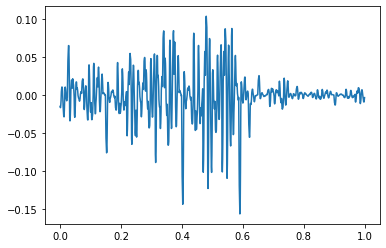

In [17]:
plt.plot(linspace, W[0,:])

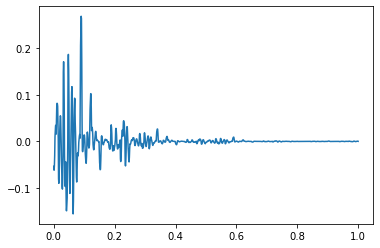

In [18]:
plt.plot(linspace, W[1,:])

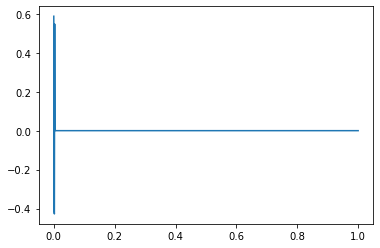

In [19]:
plt.plot(linspace, W[2,:])

Коэффициенты для синуса:

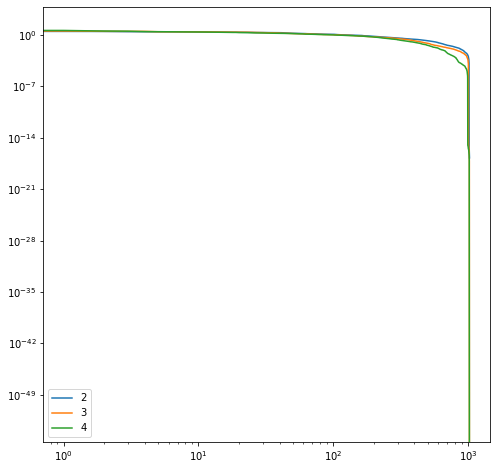

In [20]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)
sin_sq_values = values(lambda x: np.sin(500 * x ** 2), left, right, n)

wtt_coefs_sin_sq = []
for r in [2, 3, 4]:
    modes = [2] * d
    ranks = [2] + [r] * (d - 2)

    filters, _ = wtt_filter(
        sin_sq_values,
        d,
        modes,
        ranks=ranks,
        check_correctness=True
    )
    wtt_res = wtt_apply(
        sin_sq_values,
        d,
        filters,
        modes,
        ranks,
        True
    )
    wtt_coefs_sin_sq.append(np.flip(np.sort(np.abs(wtt_res))))
    
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d), wtt_coefs_sin_sq[i], label=str(r))
plt.xscale('log')
plt.yscale('log')
plt.legend()

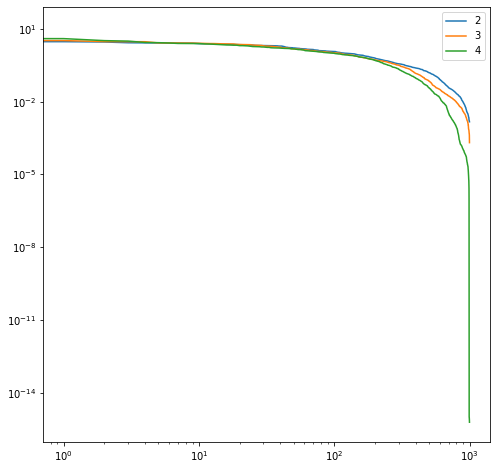

In [21]:
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d)[:1000], wtt_coefs_sin_sq[i][:1000], label=str(r))
plt.xscale('log')
plt.yscale('log')
plt.legend()

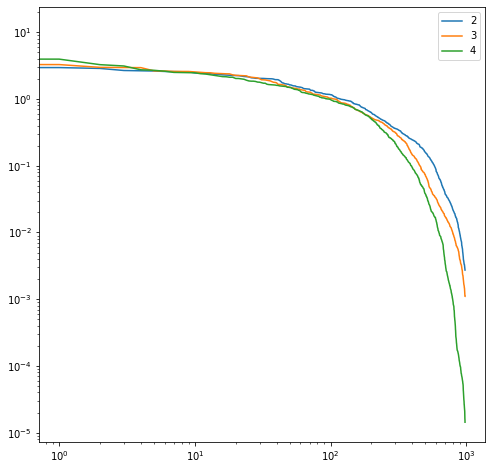

In [22]:
plt.figure(figsize=(8,8))
for i, r in enumerate([2, 3, 4]):
    plt.plot(np.arange(2 ** d)[:980], wtt_coefs_sin_sq[i][:980], label=str(r))
plt.xscale('log')
plt.yscale('log')
plt.legend()

Тесты $\varepsilon$-стратегии:

In [23]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sqrt_x_values = values(lambda x: np.sqrt(x), left, right, n)

modes = [2] * d
eps = 1e-4
filters, true_ranks = wtt_filter(sqrt_x_values, d, modes, eps=eps, check_correctness=True)
print(true_ranks)

[2, 3, 3, 3, 3, 3, 3, 3, 2]


In [24]:
eps = 1e-6
filters, true_ranks = wtt_filter(sqrt_x_values, d, modes, eps=eps, check_correctness=True)
print(true_ranks)

[2, 4, 4, 4, 5, 5, 5, 4, 2]


In [25]:
eps = 1e-8
filters, true_ranks = wtt_filter(sqrt_x_values, d, modes, eps=eps, check_correctness=True)
print(true_ranks)

[2, 4, 5, 6, 6, 6, 6, 4, 2]


Сверим также, как себя ведёт $\varepsilon$-стратегия в плане памяти. Сверимся со статьёй 2011 года.

In [26]:
d = 20
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sin_x_values = values(lambda x: np.sin(100 * x), left, right, n)

modes = [2] * d

In [27]:
epsilons = [10 ** (-4 - 2 * i) for i in range(5)]
print(epsilons)

for eps in epsilons:
    print("eps=", eps)
    filters, true_ranks = wtt_filter(sin_x_values, d, modes, eps=eps, check_correctness=True)
    wtt_result = wtt_apply(sin_x_values, d, filters, modes, true_ranks, True)
    #NNZ
    print("First two elems:", wtt_result[0], wtt_result[1])
    print("Max among last:", np.max(wtt_result[2:]))
    #ранги = 2
    print(true_ranks)
    
    memory_for_filters = 0
    for u in filters:
        memory_for_filters += u.size
    print(memory_for_filters)

[0.0001, 1e-06, 1e-08, 1e-10, 1e-12]
eps= 0.0001
First two elems: 725.656197207254 6.743501361855546e-05
Max among last: 0.0001907356659131475
[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
284
eps= 1e-06
First two elems: 725.6562012962519 -7.300180924450032e-15
Max among last: 9.013884240848282e-14
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-08
First two elems: 725.6562012962519 -7.300180924450032e-15
Max among last: 9.013884240848282e-14
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-10
First two elems: 725.6562012962519 -7.300180924450032e-15
Max among last: 9.013884240848282e-14
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308
eps= 1e-12
First two elems: 725.6562012962519 -7.300180924450032e-15
Max among last: 9.013884240848282e-14
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
308


Не совсем так, как в статье...

Во-первых, memory не 152: по идее, у нас одна матрица 2 на 2 и 19 матриц 4 на 4 с рангом 2, поэтому нам надо 308 ячеек памяти для хранения...

In [28]:
print(2 * 2 + 19 * 4 * 4)

308


Подобралось, что 152 получается так: 2 матрицы 2 на 2 (видимо, по краям) и 18 матриц 4 на 2. Но куски фильтров (матрицы $U_k$) квадратные, судя по алгоритму...

In [29]:
print(2 * 2 * 2 + 18 * 2 * 4)

152


Во-вторых, при $\varepsilon = 10^{-4}$ мы слабо округляем (мб это из-за того, что я округление поправил).

В-третьих, NNZ у нас 1, не 2.

Имплементация обратного преобразования.

Здесь ```filters``` --- фильтры, которые получены при помощи ```wtt_transform``` (фильтры для прямого преобразования; менять их не надо).

In [30]:
def iwtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [31]:
d = 10
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

sin_sq_values = values(lambda x: np.sin(500 * x ** 2), left, right, n)
modes = [2] * d
ranks = [2] * (d - 1)

filters, true_ranks = wtt_filter(
    sin_sq_values,
    d,
    modes,
    ranks=ranks,
    check_correctness=True
)

In [32]:
input_vector = np.random.rand(*sin_sq_values.shape)
wtt_result = wtt_apply(input_vector, d, filters, modes, true_ranks, True)
invwtt_result = iwtt_apply(wtt_result, d, filters, modes, true_ranks, True)
np.linalg.norm(input_vector - invwtt_result)

1.8933495201809243e-14

In [33]:
wtt_result = wtt_apply(sin_sq_values, d, filters, modes, true_ranks, True)
invwtt_result = iwtt_apply(wtt_result, d, filters, modes, true_ranks, True)
np.linalg.norm(sin_sq_values - invwtt_result)

2.6073096691598496e-14

Получается!

Применение вейвлетов в 2d: как я понимаю, надо решейпнуть матрицу $2^d \times 2^d$ в $2 \times \ldots \times 2$, затем попереставлять индексы и снова решейпнуть.

In [34]:
def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

In [35]:
def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

In [36]:
d = 5
n = 2 ** d
A = np.random.rand(n, n)
modes = [2] * d

v, new_modes = matrix_to_vector(A, d, modes, True)
assert new_modes == [4] * d

A_changed, modes_changed = vector_to_matrix(v, d, new_modes, True)
assert np.all(A_changed == A)
assert modes_changed == modes

Применение WTT к матрице: переход к вектору, обычное WTT, переход обратно к матрице.

Диск:

In [37]:
d = 10
n = 2 ** d
distances = np.fromfunction(
    lambda i, j: (i - n / 2) ** 2 + (j - n / 2) ** 2,
    (n, n)
)
A = np.ones((n, n))
A[distances <= (n ** 2) / 4] = 2
matrix_modes = [2] * d

r_max = 2
ranks = [r_max] * (d - 1)

In [38]:
eps = 1e-2
v, vector_modes = matrix_to_vector(A, d, matrix_modes)
    
filters, true_ranks = wtt_filter(v, d, vector_modes, eps=eps)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

346845
[3, 3, 3, 5, 8, 11, 15, 13, 4]
1875.896852174886


In [39]:
np.sum(np.abs(wtt_A) > 1e-8)

701731

In [40]:
eps = 1e-4
v, vector_modes = matrix_to_vector(A, d, matrix_modes)
    
filters, true_ranks = wtt_filter(v, d, vector_modes, eps=eps, ranks=ranks)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

257714
[2, 2, 2, 2, 2, 2, 2, 2, 2]
1875.8968521747681


In [41]:
np.sum(np.abs(wtt_A) > 1e-8)

790862

In [42]:
eps = 1e-8
v, vector_modes = matrix_to_vector(A, d, matrix_modes)
    
filters, true_ranks = wtt_filter(v, d, vector_modes, eps=eps, ranks=ranks)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

257714
[2, 2, 2, 2, 2, 2, 2, 2, 2]
1875.8968521747681


In [43]:
np.sum(np.abs(wtt_A) > 1e-8)

790862

Фиксированные ранги:

In [44]:
ranks = [30] * d
filters, true_ranks = wtt_filter(v, d, vector_modes, ranks=ranks, eps=0)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

464161
[4, 16, 30, 30, 30, 30, 30, 16, 4]
1875.896852174894


In [45]:
ranks = [16] * d
filters, true_ranks = wtt_filter(v, d, vector_modes, ranks=ranks, eps=0)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

454307
[4, 16, 16, 16, 16, 16, 16, 16, 4]
1875.8968521749207


In [46]:
ranks = [30] * d
eps = 10**(-4)
filters, true_ranks = wtt_filter(v, d, vector_modes, ranks=ranks, eps=eps)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

464161
[4, 16, 30, 30, 30, 30, 29, 13, 4]
1875.8968521748936


In [47]:
ranks = [16] * d
eps = 10**(-4)
filters, true_ranks = wtt_filter(v, d, vector_modes, ranks=ranks, eps=eps)
wtt_res = wtt_apply(v, d, filters, vector_modes, true_ranks)
wtt_A, _ = vector_to_matrix(wtt_res, d, vector_modes)

print(np.sum(np.isclose(wtt_A, 0)))
print(true_ranks)
print(np.linalg.norm(wtt_A))

454307
[4, 16, 16, 16, 16, 16, 16, 13, 4]
1875.8968521749207


Тесты шума: обучение на незашумлённых данных, применение к зашумлённым.

In [48]:
d = 15
n = 2 ** d
left = 0.
right = 1.

linspace = np.linspace(left, right, n)

f_values = values(lambda x: np.sin(30 * x) + np.exp(-x) - 0.1 * np.exp(np.sqrt(x)), left, right, n)

modes = [2] * d

ranks = [8] * (d - 1)

eps = 1e-8

In [49]:
filters, true_ranks = wtt_filter(f_values, d, modes, ranks=ranks, eps=eps)
true_ranks

[2, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 4, 2]

In [50]:
wtt_result = wtt_apply(f_values, d, filters, modes, true_ranks)
zeroed = np.sum(np.isclose(wtt_result, 0))
print(zeroed, wtt_result.size - zeroed)

32495 273


Также посмотрим на качество восстановления:

In [51]:
iwtt_result = iwtt_apply(wtt_result, d, filters, modes, true_ranks)
print(np.linalg.norm(iwtt_result - f_values))

1.4236586719941903e-13


In [52]:
f_values_noisy = f_values + np.random.normal(scale=1e-3, size=f_values.size)
wtt_result_noisy = wtt_apply(f_values_noisy, d, filters, modes, true_ranks)
zeroed = np.sum(np.isclose(wtt_result_noisy, 0))
print(zeroed, wtt_result_noisy.size - zeroed)

0 32768


In [53]:
iwtt_result = iwtt_apply(wtt_result_noisy, d, filters, modes, true_ranks)
print(np.linalg.norm(iwtt_result - f_values_noisy))

1.9552445409906298e-13


In [54]:
f_values_noisy_2 = f_values + np.random.normal(scale=1e-7, size=f_values.size)
wtt_result_noisy_2 = wtt_apply(f_values_noisy_2, d, filters, modes, true_ranks)
zeroed = np.sum(np.isclose(wtt_result_noisy_2, 0))
print(zeroed, wtt_result_noisy_2.size - zeroed)

2538 30230


In [55]:
iwtt_result = iwtt_apply(wtt_result_noisy_2, d, filters, modes, true_ranks)
print(np.linalg.norm(iwtt_result - f_values_noisy_2))

1.5564235394009226e-13


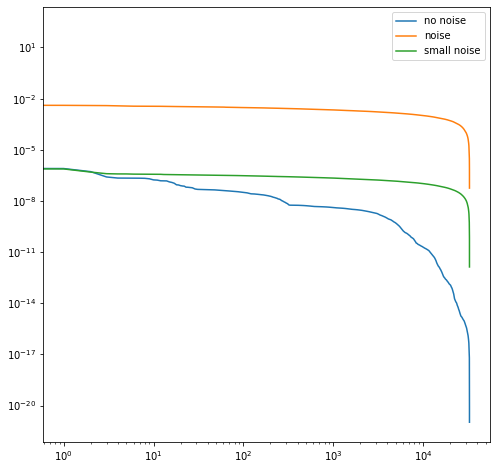

In [56]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(n), np.flip(np.sort(np.abs(wtt_result))), label='no noise')
plt.plot(np.arange(n), np.flip(np.sort(np.abs(wtt_result_noisy))), label='noise')
plt.plot(np.arange(n), np.flip(np.sort(np.abs(wtt_result_noisy_2))), label='small noise')
plt.xscale('log')
plt.yscale('log')
plt.legend()

Устойчивость фильтров при обучении на зашумлённых данных:

In [57]:
filters_noisy, _ = wtt_filter(f_values_noisy, d, modes, ranks=true_ranks)
for i in range(len(filters_noisy)):
    print(i)
    print(filters[i].shape)
    print(np.linalg.norm(filters_noisy[i] - filters[i]) / np.linalg.norm(filters[i]))

0
(2, 2)
2.9053643710552124e-06
1
(4, 4)
0.9032029653268794
2
(8, 8)
1.3698610095675363
3
(8, 8)
1.1338405917814167
4
(10, 10)
1.2803013965535432
5
(10, 10)
1.3196472322365977
6
(10, 10)
1.2028033293267388
7
(10, 10)
1.1596450804368965
8
(12, 12)
1.4229824805057953
9
(12, 12)
1.2731672386108392
10
(12, 12)
1.1991213622605157
11
(12, 12)
0.9628188712920435
12
(14, 14)
0.00721465785456697
13
(8, 8)
1.235321542929929e-05
14
(4, 4)
9.784567439278087e-06


In [58]:
filters_noisy_2, _ = wtt_filter(f_values_noisy_2, d, modes, ranks=true_ranks)
for i in range(len(filters_noisy_2)):
    print(i)
    print(filters[i].shape)
    print(np.linalg.norm(filters_noisy_2[i] - filters[i]) / np.linalg.norm(filters[i]))

0
(2, 2)
3.3512057363389364e-10
1
(4, 4)
2.732029973543086e-05
2
(8, 8)
1.0284318566618038
3
(8, 8)
0.4843360980222096
4
(10, 10)
1.0405833450985114
5
(10, 10)
1.070212013740169
6
(10, 10)
1.0863994844631597
7
(10, 10)
0.9696793909781872
8
(12, 12)
1.1297900175713118
9
(12, 12)
1.0347874179542635
10
(12, 12)
0.9987557223494091
11
(12, 12)
0.6937440461195595
12
(14, 14)
4.1970841338867277e-07
13
(8, 8)
1.495120869591674e-09
14
(4, 4)
9.596344112568272e-10


Обучение на зашумлённых фильтрах:

In [59]:
np.linalg.norm(wtt_result - wtt_apply(f_values, d, filters_noisy, modes, true_ranks))

0.020726109074055074

In [60]:
np.linalg.norm(wtt_result - wtt_apply(f_values, d, filters_noisy_2, modes, true_ranks))

2.811758840161236e-06

Попытка восстановления истинного результата зашумлёнными фильтрами:

In [61]:
np.linalg.norm(f_values - iwtt_apply(wtt_result, d, filters_noisy, modes, true_ranks))

0.020726109074044183

In [62]:
np.linalg.norm(f_values - iwtt_apply(wtt_result, d, filters_noisy_2, modes, true_ranks))

2.8117588352632517e-06

Хм, нормы получились такие же, как выше (различия в сильно младших разрядах идут). Навскидку это из-за того, что одна разность из другой получается домножением на ортогональную матрицу.